In [112]:
%matplotlib inline

# Modules
import datetime as dt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, GaussianNoise, GRU, LSTM, Conv1D, Flatten
from keras.layers.pooling import MaxPooling1D, GlobalAveragePooling1D
from keras.layers.noise import GaussianNoise
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.wrappers import Bidirectional
from keras.regularizers import l1, l2, l1_l2
from keras.layers.advanced_activations import LeakyReLU
import keras
import os
import pandas as pd

# Data
data_file_path = ''
data_filename = 'spx_history.csv'
processed_data_file = 'processed_data.csv'
model_input_file = 'model_input.csv'
predictions_file = 'predictions.csv'
dt_format = '%Y-%m-%d'

# Model
model_file = 'model.hdf5'
num_epochs = 10000
validation_frac = 0.2
batch_size = 32
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
dropout = 0.1
reg_coeff = 0.0001
neurons = 32
noise_std = 0.0
target_return = 0.20
kernel_regularizer = None # l2(reg_coeff)
outlier_std = 4
span = 2
padding = 'valid'
# Activation = LeakyReLU(alpha=0.1)
leakyalpha = 0.1
num_conv_layers = 9

# Investment decision
window = 2500 # days
investment_horizon = 250 # days
stride = 1 #days
mov_avg_period = 5 # days

In [113]:
def get_price_data(filename, dt_format):
    prices = pd.read_csv(filename,
                         delimiter=',',
                         header=0,
                         names=['date', 'P_close'],
                         index_col=0,
                         parse_dates=True,
                         date_parser=lambda date_str: dt.datetime.strptime(date_str, dt_format))
    return prices

In [114]:
def get_processed_data(prices_df, investment_horizon):
    prices_df['log_P'] = prices_df['P_close'].map(np.log)
    prices_df['diff'] = prices_df['log_P'].diff(1)
    outlier_threshold = outlier_std * prices_df['diff'].std()
    prices_df['cleaned'] = prices_df['diff'][prices_df['diff']
                                             .subtract(prices_df['diff'].mean())
                                             .abs()
                                             .lt(outlier_threshold)]
    
    
    pivot = prices_df['cleaned'].median()
    scale = prices_df['cleaned'].std()
    prices_df['scaled'] = (prices_df['cleaned'] - pivot)/scale

    prices_df['smoothed'] = prices_df['log_P'].rolling(mov_avg_period).min()
    prices_df['roll_max'] = (prices_df['smoothed']
                             .rolling(investment_horizon)
                             .max()
                             .shift(1-investment_horizon))
    prices_df['max_return'] = prices_df['roll_max'].subtract(prices_df['log_P'])

    threshold = prices_df['max_return'].mean()
#     threshold = np.log(1+target_return)
    
    print(threshold)

    def map_outcome(x):
        if x == False:
            return 0
        elif x == True:
            return 1
        else:
            return np.nan
    
    prices_df['outcome'] = prices_df['max_return'].dropna().gt(threshold).map(map_outcome)
    
    prices_df.to_csv(processed_data_file)
    print(prices_df)
    print(prices_df.describe())

    return prices_df[['scaled', 'outcome']].dropna(), pivot, scale

In [115]:
def get_samples(data_df, window, stride):
    time_series = data_df.iloc[:, 0].values
    outcomes = data_df.iloc[:, 1].values
    x, y = zip(*[(time_series[i-window:i], outcomes[i]) for i in range(window, len(time_series), stride)])
    
    return np.array(x).reshape(-1, window, 1), np.array(y).reshape(-1, 1)

In [116]:
def save_processed_data(df, filename):
    df.to_csv(filename, sep=',')

In [117]:
def get_model(window):
    
    model = keras.models.Sequential()
    
    # Convolutions
    for i in range(num_conv_layers):
        if i == 0:
            input_shape = (window, 1)
        else:
            input_shape = (None,)
        model.add(Conv1D(neurons, span, kernel_regularizer=kernel_regularizer, padding=padding, input_shape=input_shape))
        model.add(LeakyReLU(alpha=leakyalpha))
        if i < num_conv_layers-1:
            model.add(MaxPooling1D(span))
            model.add(Dropout(dropout))
#             model.add(GaussianNoise(noise_std))

    model.add(GlobalAveragePooling1D())
#     model.add(Flatten())
    
#     # Recurrents
#     model.add(GRU(128, return_sequences=True, go_backwards=True))
#     model.add(Dropout(dropout))
#     model.add(GRU(128, return_sequences=False, go_backwards=False))
#     model.add(Dropout(dropout))
    
    # Dense for final prediction
    model.add(Dense(neurons, kernel_regularizer=kernel_regularizer))
    model.add(LeakyReLU(alpha=leakyalpha))
    model.add(Dropout(dropout))
    model.add(GaussianNoise(noise_std))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=kernel_regularizer))
    
    return model

In [118]:
full_filename = os.path.join(data_file_path, data_filename)
data = get_price_data(full_filename, dt_format)
processed_data, midpoint, scale = get_processed_data(data, investment_horizon)
X, y = get_samples(processed_data, window, stride)
save_processed_data(processed_data, model_input_file)

0.138578064736
            P_close     log_P      diff   cleaned    scaled  smoothed  \
date                                                                    
1927-12-30    17.66  2.871302       NaN       NaN       NaN       NaN   
1928-01-03    17.76  2.876949  0.005647  0.005647  0.515028       NaN   
1928-01-04    17.72  2.874694 -0.002255 -0.002255 -0.270832       NaN   
1928-01-05    17.55  2.865054 -0.009640 -0.009640 -1.005358       NaN   
1928-01-06    17.66  2.871302  0.006248  0.006248  0.574873  2.865054   
1928-01-09    17.50  2.862201 -0.009101 -0.009101 -0.951781  2.862201   
1928-01-10    17.37  2.854745 -0.007456 -0.007456 -0.788169  2.854745   
1928-01-11    17.35  2.853593 -0.001152 -0.001152 -0.161157  2.853593   
1928-01-12    17.47  2.860485  0.006893  0.006893  0.638961  2.853593   
1928-01-13    17.58  2.866762  0.006277  0.006277  0.577709  2.853593   
1928-01-16    17.29  2.850128 -0.016634 -0.016634 -1.700935  2.850128   
1928-01-17    17.30  2.850707  0.000

In [119]:
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (19576, 2500, 1)
y.shape:  (19576, 1)


In [120]:
check_data = pd.DataFrame(X.reshape(-1, window))

In [121]:
print(check_data)
(check_data[-500:] * scale + midpoint).to_csv('samples.csv', sep=',')

           0         1         2         3         4         5         6     \
0      0.574873 -0.951781 -0.788169 -0.161157  0.638961  0.577709 -1.700935   
1     -0.951781 -0.788169 -0.161157  0.638961  0.577709 -1.700935  0.010935   
2     -0.788169 -0.161157  0.638961  0.577709 -1.700935  0.010935 -0.276802   
3     -0.161157  0.638961  0.577709 -1.700935  0.010935 -0.276802  0.642524   
4      0.638961  0.577709 -1.700935  0.010935 -0.276802  0.642524  0.524049   
5      0.577709 -1.700935  0.010935 -0.276802  0.642524  0.524049  0.859667   
6     -1.700935  0.010935 -0.276802  0.642524  0.524049  0.859667  0.347326   
7      0.010935 -0.276802  0.642524  0.524049  0.859667  0.347326 -1.119375   
8     -0.276802  0.642524  0.524049  0.859667  0.347326 -1.119375  0.575933   
9      0.642524  0.524049  0.859667  0.347326 -1.119375  0.575933  0.291341   
10     0.524049  0.859667  0.347326 -1.119375  0.575933  0.291341 -1.177444   
11     0.859667  0.347326 -1.119375  0.575933  0.291

In [122]:
data.describe()

,P_close,log_P,diff,cleaned,scaled,smoothed,roll_max,max_return,outcome
count,22504.000000,22504.000000,22503.000000,22328.000000,22328.000000,22500.000000,22251.000000,22251.000000,22251.000000
mean,399.850251,4.734416,0.000220,0.000300,-0.016703,4.723103,4.839718,0.138578,0.427531
std,573.245719,1.723863,0.011763,0.010054,1.000000,1.725022,1.689655,0.111641,0.494732
min,4.400000,1.481605,-0.228997,-0.046789,-4.700143,1.481605,2.169054,-0.056723,0.000000
25%,22.987500,3.134951,-0.004572,-0.004484,-0.492543,3.124125,3.247658,0.055959,0.000000
50%,96.700000,4.571613,0.000460,0.000468,0.000000,4.563671,4.653770,0.116761,0.000000
75%,503.140000,6.220868,0.005369,0.005334,0.483910,6.216027,6.298912,0.202656,1.000000
max,2477.830000,7.815138,0.153661,0.047108,4.638755,7.812095,7.812095,0.988453,1.000000


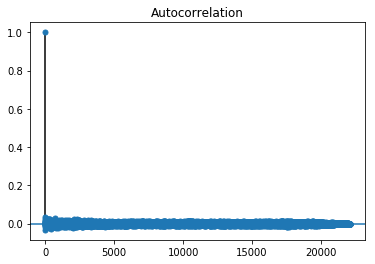

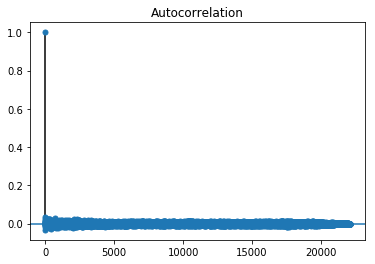

In [123]:
plot_acf(processed_data['scaled'])

In [124]:
pyplot.show()

In [125]:
model = get_model(window)
model.summary()
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 2499, 32)          96        
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 2499, 32)          0         
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1249, 32)          0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 1248, 32)          2080      
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 1248, 32)          0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 624, 32)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 623, 32)           2080      
__________

In [126]:
checkpointer = ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=10)

training_history = model.fit(X, y, batch_size=batch_size, epochs=num_epochs, verbose=1,
          callbacks=[checkpointer, earlystopper], validation_split=validation_frac)

Train on 15660 samples, validate on 3916 samples
Epoch 1/10000
15660/15660 [==============================] - 98s - loss: 0.6672 - acc: 0.5787 - val_loss: 0.6834 - val_acc: 0.5666
Epoch 2/10000
15660/15660 [==============================] - 101s - loss: 0.5602 - acc: 0.7089 - val_loss: 0.7968 - val_acc: 0.5301
Epoch 3/10000
15660/15660 [==============================] - 95s - loss: 0.4189 - acc: 0.8158 - val_loss: 1.0800 - val_acc: 0.4890
Epoch 4/10000
15660/15660 [==============================] - 96s - loss: 0.3122 - acc: 0.8691 - val_loss: 1.3046 - val_acc: 0.5005
Epoch 5/10000
15660/15660 [==============================] - 96s - loss: 0.2412 - acc: 0.9026 - val_loss: 2.0223 - val_acc: 0.4768
Epoch 6/10000
15660/15660 [==============================] - 97s - loss: 0.1959 - acc: 0.9236 - val_loss: 2.6479 - val_acc: 0.4773
Epoch 7/10000
15660/15660 [==============================] - 96s - loss: 0.1628 - acc: 0.9384 - val_loss: 2.2975 - val_acc: 0.4987
Epoch 8/10000
15660/15660 [======

In [127]:
predictions = model.predict(X, verbose=1)

19576/19576 [==============================] - 51s    


In [128]:
predictions.shape

(19576, 1)

In [129]:
pd.DataFrame(predictions).describe()

,0
count,1.957600e+04
mean,4.482507e-01
std,4.613859e-01
min,1.305580e-08
25%,3.900848e-03
50%,1.546875e-01
75%,9.983435e-01
max,1.000000e+00


In [130]:
pd.Series(predictions.squeeze()).to_csv(predictions_file, sep=',')